In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

import folium
import folium.plugins
from folium.plugins import MarkerCluster
from ipywidgets import interactive

!pip install tensorflow
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

  Stored in directory: C:\Users\henry\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Stored in directory: C:\Users\henry\AppData\Local\pip\Cache\wheels\a7\15\a0\0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Stored in directory: C:\Users\henry\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\henry\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built opt-einsum absl-py gast termcolor


tensorboard 2.0.1 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
Using TensorFlow backend.


In [4]:
crime = pd.read_csv('crimetodate_cleaneddata.csv') 
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399636 entries, 0 to 399635
Data columns (total 20 columns):
Unnamed: 0             399636 non-null int64
INCIDENT_NUMBER        399636 non-null object
OFFENSE_CODE           399636 non-null int64
OFFENSE_CODE_GROUP     399636 non-null object
OFFENSE_DESCRIPTION    399636 non-null object
DISTRICT               397816 non-null object
REPORTING_AREA         399636 non-null object
SHOOTING               399636 non-null int64
YEAR                   399636 non-null int64
MONTH                  399636 non-null int64
DAY_OF_WEEK            399636 non-null object
HOUR                   399636 non-null int64
UCR_PART               399527 non-null object
STREET                 397111 non-null object
Lat                    399636 non-null float64
Long                   399636 non-null float64
Location_lat           399636 non-null float64
Location_long          399636 non-null float64
date_occured           399636 non-null object
occured_on_dttm  

min data date : 2015-06-15 00:00:00
max data date : 2019-10-13 09:28:24
Incomplete Year Data on 2015 & 2019


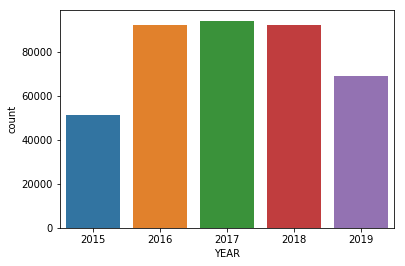

In [5]:
sns.countplot("YEAR", data = crime) 
print("min data date :", min(crime.occured_on_dttm)) 
print("max data date :", max(crime.occured_on_dttm))
print("Incomplete Year Data on 2015 & 2019")

In [88]:
# plotting Crime distribution by Day of Week and comparing the years

def week(Year):
    return sns.countplot("DAY_OF_WEEK",order=crime.DAY_OF_WEEK.value_counts().index, data = crime[crime.YEAR == Year])
interactive(week,Year=(2015,2019,1))

#import matplotlib.pyplot as plt
#import matplotlib.animation as animation
#fig = plt.figure()
#sns.set_palette("pastel")
#def init():
#    sns.countplot("DAY_OF_WEEK",order=crime.DAY_OF_WEEK.value_counts().index, data = crime[crime.YEAR])

#anim = animation.FuncAnimation(fig, init_func=init, frames=5, repeat = False)$


interactive(children=(IntSlider(value=2017, description='Year', max=2019, min=2015), Output()), _dom_classes=(…

In [79]:
#plotting Crime Distribution by hour
#result = starts from 7AM & Peaks in the Afternoon (4pm to 7pm) -- this is true across all 4 years

#2k15
def hour(Year):
    return sns.countplot("HOUR", data =  crime[crime.YEAR == Year])
interactive(hour,Year=(2015,2019,1))

interactive(children=(IntSlider(value=2017, description='Year', max=2019, min=2015), Output()), _dom_classes=(…

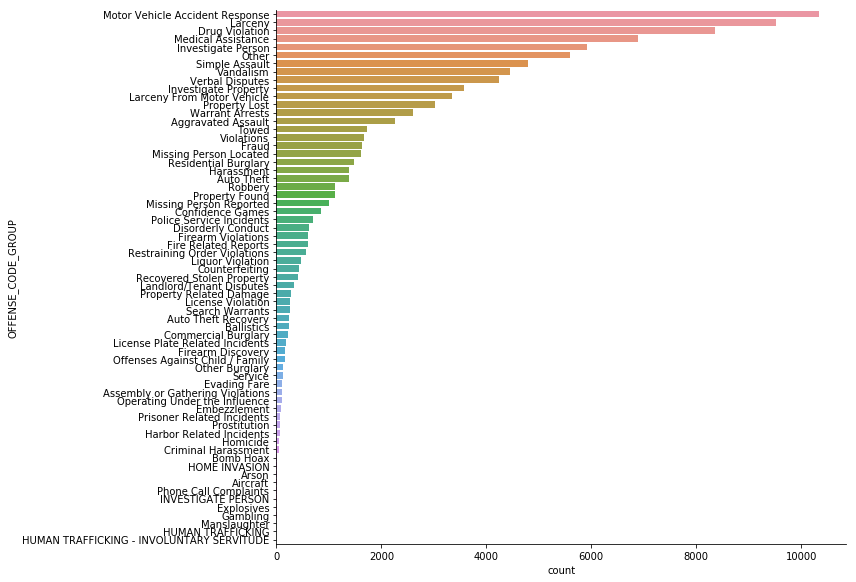

In [8]:
##Offense Group During Peak Time (4pm to 7 pm, 11pm to 12am)
hr = crime[(crime.HOUR >= 16) & (crime.HOUR <=19) | (crime.HOUR >= 23) &(crime.HOUR <=0)]

sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
            height=8, 
            aspect=1.5,
            order=hr.OFFENSE_CODE_GROUP.value_counts().index,
           data=hr)

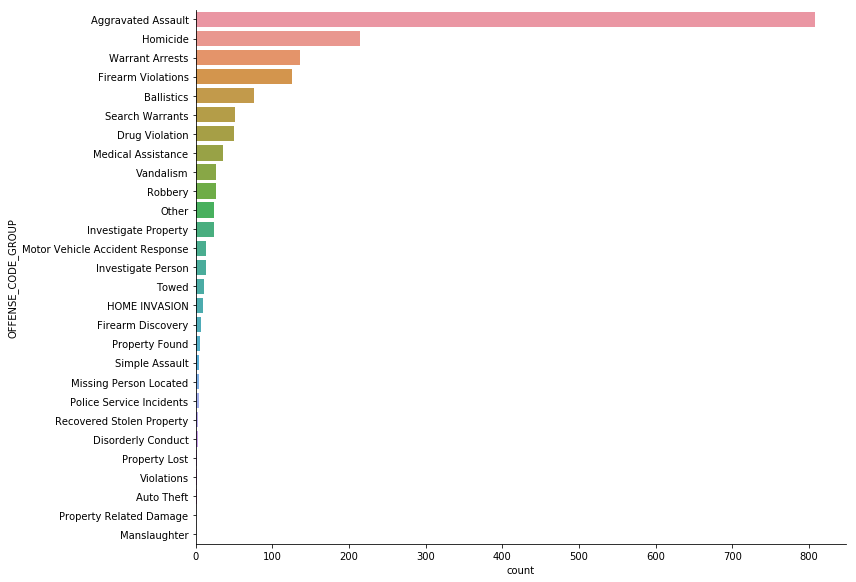

In [9]:
#type of offense code where there is shootings
shtgs = crime[crime.SHOOTING == 1]


sns.catplot(y='OFFENSE_CODE_GROUP',
           kind='count',
            height=8, 
            aspect=1.5,
            order=shtgs.OFFENSE_CODE_GROUP.value_counts().index,
           data=shtgs)

In [10]:
#Finding areas where there is more than 5 crime incidents
tmp = crime.groupby('INCIDENT_NUMBER')['YEAR'].count().sort_values(ascending = False)
tmp = pd.DataFrame({'INCIDENT_NUMBER': tmp.index, 'NUM_RECORDS': tmp.values})
seriousCrimes = crime.merge(tmp[tmp['NUM_RECORDS'] > 7], on = 'INCIDENT_NUMBER', how = 'inner')
seriousCrimes = seriousCrimes[['OFFENSE_CODE_GROUP','Lat','Long','NUM_RECORDS','STREET']].drop_duplicates()

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

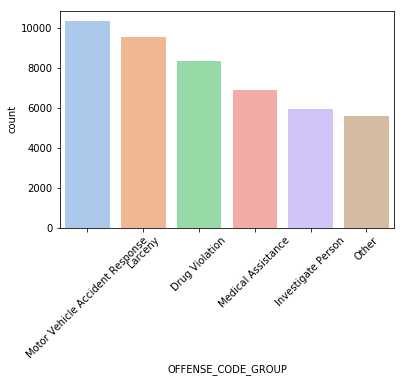

In [19]:
##Top Six Offense Group During Peak Time (4pm to 7 pm, 11pm to 12am)
hr = crime[(crime.HOUR >= 16) & (crime.HOUR <=19) | (crime.HOUR >= 23) &(crime.HOUR <=0)]
order = hr['OFFENSE_CODE_GROUP'].value_counts().head(6).index
sns.countplot(data = hr, x='OFFENSE_CODE_GROUP', order = order)
plt.xticks(rotation=45)

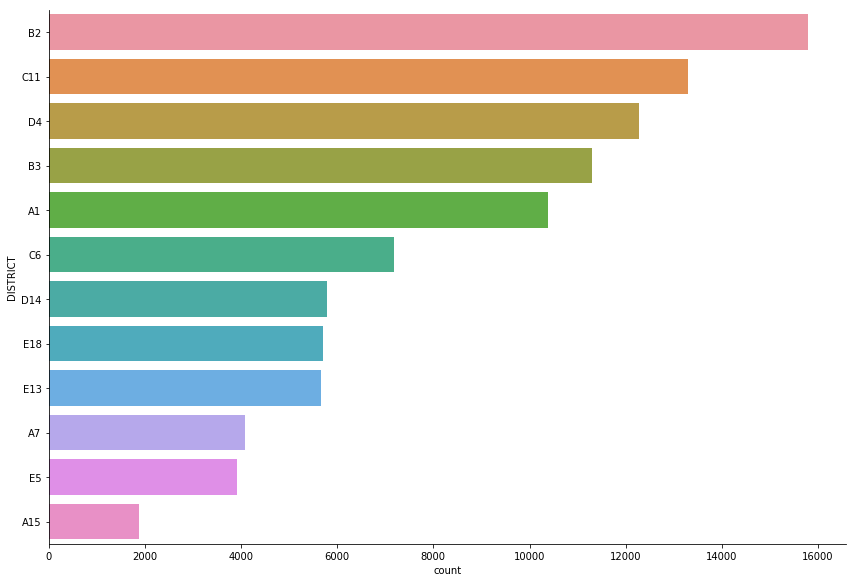

In [20]:
##Crime Count on DISTRICT During Peak Time (4pm to 7 pm, 11pm to 12am)
sns.catplot(y='DISTRICT',
           kind='count',
            height=8, 
            aspect=1.5,
            order=hr.DISTRICT.value_counts().index,
           data=hr)

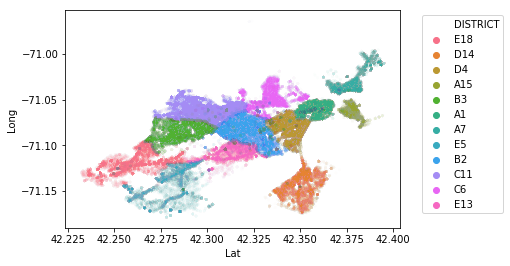

In [35]:
# replaces -1 values with None
crime.Lat.replace(-1,None,inplace=True)
crime.Long.replace(-1,None,inplace=True)

# identifies the distict where crime occur 
sns.scatterplot(x='Lat',y='Long', data=crime, alpha=0.01, hue='DISTRICT', s= 10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
crime_freq=crime.groupby(['Lat', 'Long'],as_index=False).agg({"INCIDENT_NUMBER":"count"})

In [11]:
# Used this tutorial: https://medium.com/@bobhaffner/folium-markerclusters-and-fastmarkerclusters-1e03b01cb7b1
boston = folium.Map(location = [seriousCrimes['Lat'].mean(), 
                                  seriousCrimes['Long'].mean()], 
                      zoom_start = 12)
mc = MarkerCluster()
#creating a Marker for each point. 
for row in seriousCrimes.itertuples():
    mc.add_child(folium.Marker(location = [row.Lat, row.Long]))
boston.add_child(mc)

boston

In [12]:
###shooting data
shtng = crime[(crime.SHOOTING == 1) & (crime.DISTRICT.notnull())]

boston1 = folium.Map(location = [shtng['Lat'].mean(), 
                                  shtng['Long'].mean()], 
                      zoom_start = 12)
mc = MarkerCluster()
#creating a Marker for each point. 
for row in shtng.itertuples():
    mc.add_child(folium.Marker(location = [row.Lat,  row.Long]))

boston1.add_child(mc)

boston1